In [1]:
import os 
from tools import data_tools as dt
from tools import kelp_tools_windows as kt
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.errors import RasterioIOError

In [36]:
path = rf'C:\Users\attic\HLS_Kelp\imagery\Isla_vista_kelp_2018\11SKU'
granule= 'HLS.L30.T11SKU.2018042T183356.v2.0'
img_path = os.path.join(path, granule)

In [37]:
sorted_files = kt.filter_and_sort_files(img_path,granule)
land_mask = kt.create_land_mask(os.path.join(path,granule,sorted_files[0]))
cloud_land_mask, cloud_but_not_land_mask, percent_cloud_covered = kt.create_qa_mask(land_mask, img_path)
img_bands =[]
transform=None
try:
    for file in sorted_files:
        with rasterio.open(os.path.join(img_path, file)) as src:
            img_bands.append(np.where(land_mask, 0, np.asarray(src.read(1))))
            if(transform is None):
                transform = src.transform
                crs= src.crs

    del cloud_land_mask
    img = np.stack(img_bands, axis=0)
except RasterioIOError as e:
    print(f"Error reading file {file} in granule {granule}: {e}")

In [50]:
ndvi = (img[3,:,:]-img[2,:,:])/(img[3] + img[2])
ndvi_fltr = np.where(abs(ndvi) < 5, ndvi, np.nan)

C:\Users\attic\AppData\Local\Temp\ipykernel_22768\1615175616.py:1: RuntimeWarning: divide by zero encountered in divide
  ndvi = (img[3,:,:]-img[2,:,:])/(img[3] + img[2])
C:\Users\attic\AppData\Local\Temp\ipykernel_22768\1615175616.py:1: RuntimeWarning: invalid value encountered in divide
  ndvi = (img[3,:,:]-img[2,:,:])/(img[3] + img[2])


In [90]:
ndvi = np.where(np.isfinite(ndvi), ndvi, -1)
local_variance_gpu = kt.calculate_local_variance(ndvi,5)

#local_variance_gpu = np.where(~np.isfinite(local_variance_gpu), , local_variance_gpu)

max_local_variance = np.percentile(local_variance_gpu, 90)
print(max_local_variance)
ndvi_variance_mask = np.where(local_variance_gpu > 4, np.nan, ndvi)
ndvi_variance_mask = np.where(ndvi == -1, np.nan, ndvi)
ndvi_variance_mask = np.where(abs(ndvi_variance_mask) > 1, np.nan, ndvi_variance_mask)

0.1273700654506683


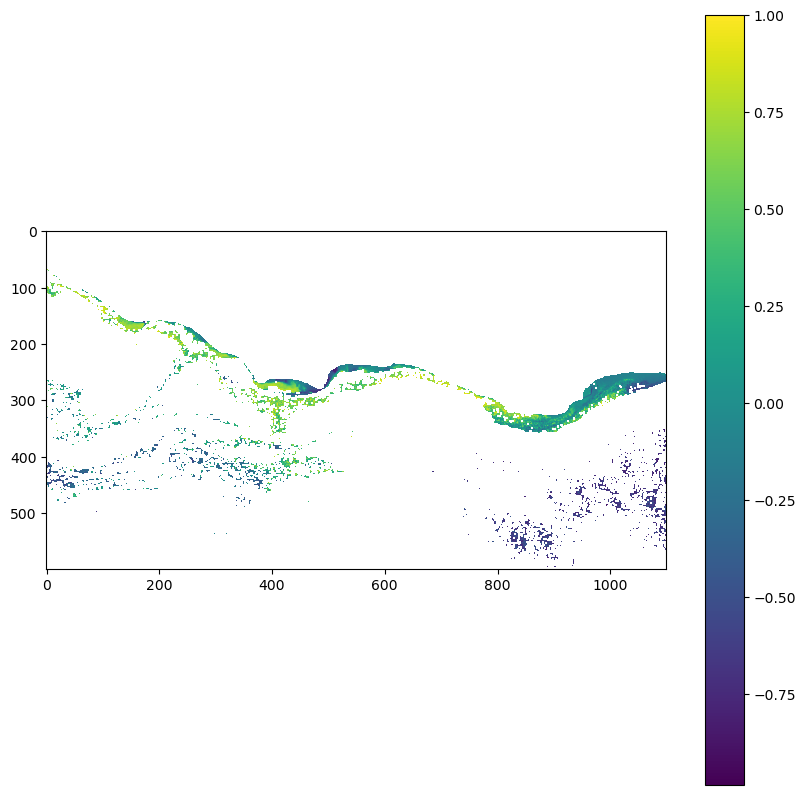

In [91]:
plt.figure(figsize=(10,10))
plt.imshow(ndvi_variance_mask[2700:3300,800:1900])
#plt.imshow(local_variance_gpu[2700:3300,800:1900])
plt.colorbar()